In [22]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from utils import Logger
from tqdm import tqdm
from IPython import display

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    running_on = 'GPU'
else:
    device = torch.device('cpu')
    running_on = 'CPU'
print(f'Torch running on : {running_on}')

Torch running on : GPU


## Helper Functions

In [25]:
def images_to_vector(image):
    return image.view(image.size(0), 784)

def vector_to_images(vector):
    return vector.view(vector.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

## Importing and Transforming the Data

In [18]:
train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)



0it [00:00, ?it/s]



  0%|                                                                                      | 0/9912422 [00:02<?, ?it/s]

  0%|▏                                                                     | 24576/9912422 [00:02<00:49, 200980.37it/s]

  0%|▎                                                                     | 49152/9912422 [00:02<00:48, 204905.51it/s]

  1%|▍                                                                     | 65536/9912422 [00:02<00:52, 188596.53it/s]

  1%|▋                                                                     | 90112/9912422 [00:02<00:48, 202355.91it/s]

  1%|▊                                                                    | 122880/9912422 [00:02<00:44, 221643.91it/s]

  2%|█                                                                    | 155648/9912422 [00:02<00:42, 227171.07it/s]

  2%|█▎                                                                   | 196608/9912422 [00:02<00:38, 252511.06it/s]

  2%|█▌                       

Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw





0it [00:00, ?it/s]




  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]


32768it [00:01, 28348.61it/s]                                                                                          



0it [00:00, ?it/s]

Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw





  0%|                                                                                      | 0/1648877 [00:00<?, ?it/s]


  1%|▋                                                                      | 16384/1648877 [00:01<00:31, 51986.84it/s]


  2%|█▊                                                                     | 40960/1648877 [00:01<00:27, 58040.19it/s]


  4%|██▊                                                                    | 65536/1648877 [00:01<00:21, 73483.97it/s]


  5%|███▌                                                                   | 81920/1648877 [00:01<00:17, 87517.79it/s]


  6%|████▌                                                                 | 106496/1648877 [00:01<00:15, 99872.24it/s]


  8%|█████▊                                                               | 139264/1648877 [00:01<00:12, 123385.88it/s]


 10%|███████▏                                                             | 172032/1648877 [00:02<00:09, 148132.74it/s]


 13%|█████████▎      

Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw






8192it [00:00, 9978.25it/s]                                                                                            


Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
Processing...
Done!




9920512it [00:47, 463059.80it/s]

In [7]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Num batches
num_batches = len(data_loader)

0it [00:00, ?it/s]

26427392it [03:06, 82150.02it/s]                                                                                       

Extracting ./dataset\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./dataset\FashionMNIST\raw



0it [00:00, ?it/s]


32768it [00:00, 32842.23it/s]                                                                                          

0it [00:00, ?it/s]

Extracting ./dataset\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./dataset\FashionMNIST\raw



 99%|███████████████████████████████████████████████████████████████████▌| 4390912/4422102 [00:08<00:00, 611594.74it/s]

0it [00:00, ?it/s]

Extracting ./dataset\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset\FashionMNIST\raw




8192it [00:00, 9433.73it/s]                                                                                            


Extracting ./dataset\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset\FashionMNIST\raw
Processing...
Done!


26427392it [03:20, 82150.02it/s]
4423680it [00:20, 611594.74it/s]                                                                                       

In [ ]:
data_loader.dataset.train_data.shape

## Defining the Discriminator Network

In [35]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        INPUT_FEATURES = 784
        OUTPUT_NODES   = 1
        
        self.layer1 = nn.Sequential(
                        nn.Linear(INPUT_FEATURES, 1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.layer2 = nn.Sequential(
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.layer3 = nn.Sequential(
                        nn.Linear(512, 256),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.output = nn.Sequential(
                        nn.Linear(256, OUTPUT_NODES),
                        nn.Sigmoid()
                        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)            
        x = self.layer3(x)            
        x = self.output(x)
        return x

## Defining the Generative Network

In [36]:
class Generative(torch.nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        INPUT_FEATURES = 100
        OUTPUT_NODES   = 784
        
        self.layer1 = nn.Sequential(
                        nn.Linear(INPUT_FEATURES, 256),
                        nn.LeakyReLU(0.2)
                        )
        
        self.layer2 = nn.Sequential(
                        nn.Linear(256, 512),
                        nn.LeakyReLU(0.2)
                        )
        
        self.layer3 = nn.Sequential(
                        nn.Linear(512, 1024),
                        nn.LeakyReLU(0.2)
                        )
        
        self.output = nn.Sequential(
                        nn.Linear(1024, OUTPUT_NODES),
                        nn.Tanh()
                        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)            
        x = self.layer3(x)            
        x = self.output(x)
        return x

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [40]:
discriminator = Discriminator().to(device)
generator     = Generative().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

loss = nn.BCELoss()

In [41]:
num_test_samples = 16
test_noise = noise(num_test_samples)

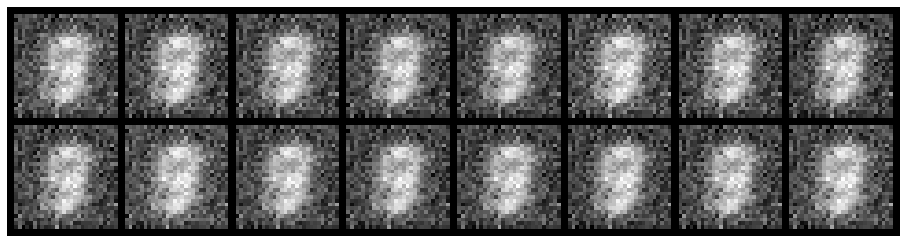

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.9753, Generator Loss: 1.1434
D(x): 0.6020, D(G(z)): 0.3684


KeyboardInterrupt: 

In [43]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
EPOCHS = 200

for epoch in tqdm(range(EPOCHS)):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vector(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vector_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, EPOCHS, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)